In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter % 5 == 0:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
#trafic_index = dict(pd.read_csv('data/processed/Full_data_set.csv', parse_dates = [8]).Reservation_Time.dt.hour.value_counts())

In [4]:
tdf = pd.read_csv('data/processed/Vacancy_new.csv', parse_dates=[2,3])
tdf['park_time'] = tdf.park_time.round('h').dt.hour
trafic_index = dict(tdf.groupby('park_time').mean()['time_to_reservation'])

## Simple network

In [5]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# No more than 3 days
df = df[df.time_to_reservation < 72]

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])

y = df.time_to_reservation

df.drop(columns=['time_to_reservation', 'time', 'park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF', 'degree'], inplace = True)
df

,park_fuel,weekend,hour_index,eng_118I,eng_COOPER,eng_I3,eng_X1,lz_102111,lz_102121,lz_102122,...,lz_185122,lz_185123,lz_185124,lz_185131,lz_185132,lz_185141,lz_185142,lz_185143,lz_185154,lz_185203
0,86,0,6.805269,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,84,0,6.805269,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,84,0,6.805269,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,50,0,6.805269,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,6.805269,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340479,59,0,6.457874,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340480,50,0,6.457874,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340481,31,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340482,58,0,6.457874,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [7]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(268,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(nn.BatchNorm1d(32)),
            nn.Dropout(0.5),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=268, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
) 45249


In [8]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 22.790990 , Valid Loss 18.889619 ,Train R2 0.142599, Valid R2 0.144473
Epoch 11: Train Loss 19.288097 , Valid Loss 18.395746 ,Train R2 0.177519, Valid R2 0.166841
EarlyStopping counter: 5 out of 10
Epoch 21: Train Loss 18.918946 , Valid Loss 18.347977 ,Train R2 0.185597, Valid R2 0.169004
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 25: Train Loss 18.880021 , Valid Loss 18.356993 , Train R2 0.187358, Valid R2 0.168596


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

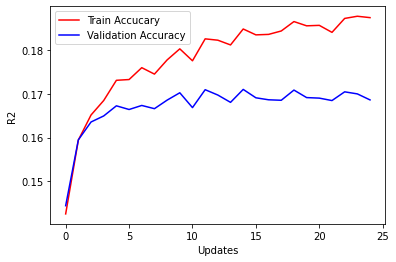

In [9]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

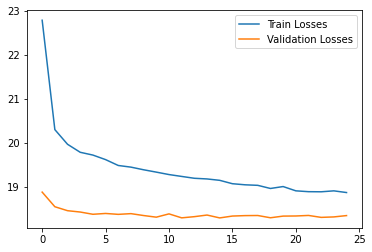

0.1588597202075719


In [10]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With embedding

In [ ]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.embedding = nn.Embedding 

        self.seq = nn.Sequential(
            nn.Linear(263,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,32),
            nn.ReLU(nn.BatchNorm1d(32)),
            nn.Dropout(0.5),
            nn.Linear(32,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

In [344]:
X_train[2,7:].int().argmax()

tensor(146)

In [345]:
emb(X_train[:,7:].int())[2,:,:]

tensor([[-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
        [-0.4719,  0.0238, -1.0300],
 

In [319]:
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
emb(input)

tensor([[[-1.1585,  2.0188,  2.1123],
         [ 0.7063, -1.2334, -0.2562],
         [-1.9014,  0.3058,  0.3674],
         [ 0.5342, -1.6928, -0.4252]],

        [[-1.9014,  0.3058,  0.3674],
         [ 1.0778,  0.6448,  0.6322],
         [ 0.7063, -1.2334, -0.2562],
         [-1.2688, -0.6102,  0.4146]]], grad_fn=<EmbeddingBackward0>)

In [291]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*lz).*$')-train_data.filter(regex = '^(?!.*lz).*$').mean())/train_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), train_data.filter(regex = 'lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*lz).*$')-val_data.filter(regex = '^(?!.*lz).*$').mean())/val_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), val_data.filter(regex = 'lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*lz).*$')-test_data.filter(regex = '^(?!.*lz).*$').mean())/test_data.filter(regex = '^(?!.*lz).*$').std(ddof = 1), test_data.filter(regex = 'lz')], axis = 1)

In [292]:
X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

## With degree

In [11]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# No more than 3 days
df = df[df.time_to_reservation < 72]

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])


y = df.time_to_reservation
df.drop(columns=['time_to_reservation', 'time', 'park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF'], inplace = True)

In [12]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [13]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(269,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=269, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60033


In [14]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.001) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 22.025089 , Valid Loss 18.584055 ,Train R2 0.167279, Valid R2 0.171675
Epoch 11: Train Loss 18.466408 , Valid Loss 17.861365 ,Train R2 0.218862, Valid R2 0.203886
Epoch 21: Train Loss 18.252154 , Valid Loss 17.823065 ,Train R2 0.227546, Valid R2 0.205594
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 27: Train Loss 18.122504 , Valid Loss 17.866169 , Train R2 0.230212, Valid R2 0.203672


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

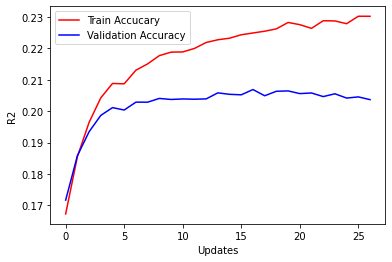

In [15]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss_train.append(batch_loss.item())
    train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

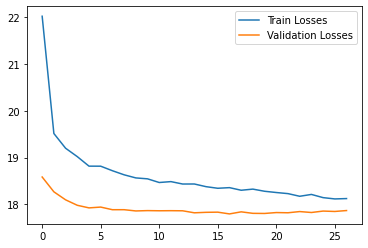

0.20730574196577745


In [16]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## With weather

In [17]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

# No more than 4 days
df = df[df.time_to_reservation < 72]

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])

# Joine weather
df_weather = pd.read_csv('data/processed/weather.csv', index_col=0, parse_dates=[0])
df.time = df.time.round('H')
df = df.set_index('time').join(df_weather).reset_index()
del df_weather

# Make y and x
y = df.time_to_reservation
df.drop(columns=['time_to_reservation', 'index', 'park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF'], inplace = True)

In [18]:
pd.concat([pd.DataFrame(y),df.iloc[:,-7:]],axis = 1).corr()
#1.000000	-0.073216	-0.080221	-0.041373	-0.105149	0.015708	0.125081	-0.00846

,time_to_reservation,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover
time_to_reservation,1.000000,-0.044307,-0.068198,-0.012008,-0.096155,0.016595,0.066291,-0.002619
mean_temp,-0.044307,1.000000,-0.043385,0.022393,0.396614,0.313042,-0.456779,-0.228585
mean_wind_speed,-0.068198,-0.043385,1.000000,0.064525,0.004018,-0.289847,-0.144457,0.189008
acc_precip,-0.012008,0.022393,0.064525,1.000000,-0.119413,-0.156752,0.209328,0.199918
bright_sunshine,-0.096155,0.396614,0.004018,-0.119413,1.000000,0.338694,-0.560049,-0.567037
mean_pressure,0.016595,0.313042,-0.289847,-0.156752,0.338694,1.000000,-0.402337,-0.414902
mean_relative_hum,0.066291,-0.456779,-0.144457,0.209328,-0.560049,-0.402337,1.000000,0.474065
mean_cloud_cover,-0.002619,-0.228585,0.189008,0.199918,-0.567037,-0.414902,0.474065,1.000000


In [19]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [20]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(276,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=276, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60929


In [21]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.092764 , Valid Loss 19.005115 ,Train R2 0.153035, Valid R2 0.152680
Epoch 11: Train Loss 17.669540 , Valid Loss 17.892829 ,Train R2 0.216170, Valid R2 0.202270
Epoch 21: Train Loss 17.454895 , Valid Loss 17.799147 ,Train R2 0.225692, Valid R2 0.206446
EarlyStopping counter: 5 out of 10
Epoch 31: Train Loss 17.383577 , Valid Loss 17.875235 ,Train R2 0.228855, Valid R2 0.203054
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 32: Train Loss 17.335505 , Valid Loss 17.812348 , Train R2 0.230988, Valid R2 0.205858


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

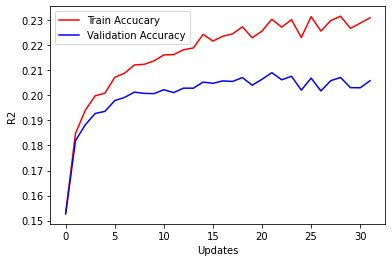

In [22]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

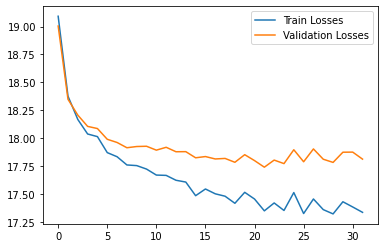

0.2023904628001234


In [23]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

## Average weather

In [24]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

# No more than 4 days
df = df[df.time_to_reservation < 72]

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])

# Join weather
df['park_time'] = df.time.round('H')
df['reserve_time'] = (df.time+pd.to_timedelta(df.time_to_reservation,'h')).round('H')

df_weather = pd.read_csv('data/processed/weather.csv', index_col=0, parse_dates=[0])

weather_average = pd.DataFrame(data=[df_weather.loc[
    pd.to_datetime(np.linspace(row.park_time.value, row.reserve_time.value, int((row.reserve_time-row.park_time)/ np.timedelta64(1, 'h'))+1)) 
    ].mean().values for _, row in tqdm(df.iterrows(), total = len(df))
], columns = df_weather.columns, index = df.index)

df = pd.concat([df ,weather_average], axis = 1)

del df_weather#, weather_average

# Make y and x
y = df.time_to_reservation
df.drop(columns=['time_to_reservation', 'time','park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF', 'park_time', 'reserve_time'], inplace = True)

100%|██████████| 326701/326701 [06:35<00:00, 825.88it/s]


In [25]:
pd.concat([pd.DataFrame(y),df.iloc[:,-7:]],axis = 1).corr()

,time_to_reservation,mean_temp,mean_wind_speed,acc_precip,bright_sunshine,mean_pressure,mean_relative_hum,mean_cloud_cover
time_to_reservation,1.000000,-0.073216,-0.080221,-0.041373,-0.105149,0.015708,0.125081,-0.008462
mean_temp,-0.073216,1.000000,-0.053112,0.028358,0.419013,0.314081,-0.448210,-0.242389
mean_wind_speed,-0.080221,-0.053112,1.000000,0.071476,-0.002467,-0.293972,-0.145228,0.203421
acc_precip,-0.041373,0.028358,0.071476,1.000000,-0.132294,-0.177643,0.224917,0.219829
bright_sunshine,-0.105149,0.419013,-0.002467,-0.132294,1.000000,0.362242,-0.610405,-0.607366
mean_pressure,0.015708,0.314081,-0.293972,-0.177643,0.362242,1.000000,-0.405827,-0.439496
mean_relative_hum,0.125081,-0.448210,-0.145228,0.224917,-0.610405,-0.405827,1.000000,0.499450
mean_cloud_cover,-0.008462,-0.242389,0.203421,0.219829,-0.607366,-0.439496,0.499450,1.000000


In [26]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [27]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(276,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=276, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60929


In [28]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 18.502531 , Valid Loss 18.394012 ,Train R2 0.179733, Valid R2 0.177575
Epoch 11: Train Loss 12.351814 , Valid Loss 13.257565 ,Train R2 0.452411, Valid R2 0.407233
Epoch 21: Train Loss 11.786485 , Valid Loss 12.944876 ,Train R2 0.477473, Valid R2 0.421214
Epoch 31: Train Loss 11.351941 , Valid Loss 12.574662 ,Train R2 0.496738, Valid R2 0.437767
Epoch 41: Train Loss 11.056255 , Valid Loss 12.418234 ,Train R2 0.509846, Valid R2 0.444761
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 50: Train Loss 11.120123 , Valid Loss 12.420075 , Train R2 0.507015, Valid R2 0.444679


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

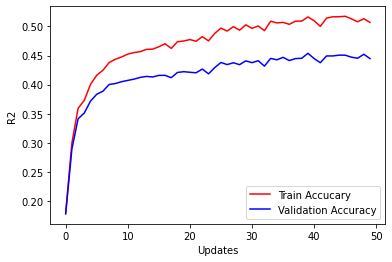

In [29]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

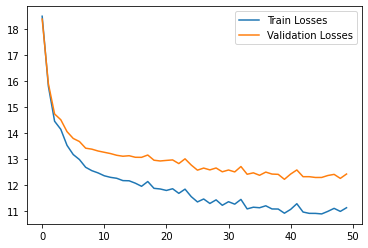

0.43616669366254424


In [30]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

[]

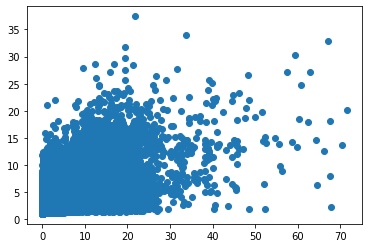

In [31]:
plt.scatter(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0])
plt.plot()

## Only average weather

In [32]:
df_w = df.iloc[:,-7:]

train_val, test_data, y_train_val, y_test = train_test_split(df_w, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [33]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(7,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 26497


In [34]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 21.387835 , Valid Loss 21.676424 ,Train R2 0.054500, Valid R2 0.051885
Epoch 11: Train Loss 15.025988 , Valid Loss 15.363680 ,Train R2 0.335741, Valid R2 0.328001
Epoch 21: Train Loss 14.194134 , Valid Loss 14.523945 ,Train R2 0.372515, Valid R2 0.364730
Epoch 31: Train Loss 13.846296 , Valid Loss 14.172030 ,Train R2 0.387892, Valid R2 0.380123
Epoch 41: Train Loss 13.280391 , Valid Loss 13.639991 ,Train R2 0.412909, Valid R2 0.403394
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 51: Train Loss 13.430838 , Valid Loss 13.805029 , Train R2 0.406258, Valid R2 0.396175


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

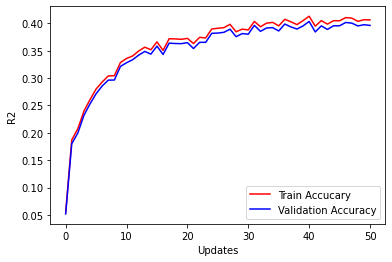

In [35]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

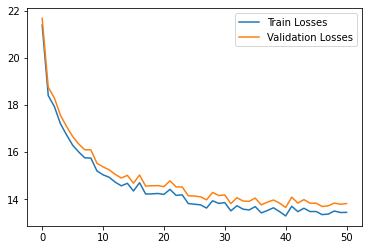

0.39913391601942116


In [36]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))

In [ ]:
weather_average = pd.DataFrame(data=[df_weather.loc[
    pd.to_datetime(np.linspace(row.park_time.value, row.reserve_time.value, int((row.reserve_time-row.park_time)/ np.timedelta64(1, 'h'))+1)) 
    ].mean().values for _, row in tqdm(df.iterrows(), total = len(df))
], columns = df_weather.columns, index = df.index)

In [50]:
row = next(df.iterrows())[1]

In [55]:
row

time                   2019-10-31 00:00:11
time_to_reservation               9.015833
park_location_lat                55.715202
park_location_long                12.57333
leave_location_lat               55.715202
                              ...         
lz_185142                                0
lz_185143                                0
lz_185154                                0
lz_185203                                0
park_time              2019-10-31 00:00:00
Name: 0, Length: 280, dtype: object

In [76]:
row.park_time+pd.to_timedelta(round(row.hour_index), 'h')-row.park_time

Timedelta('0 days 07:00:00')

In [77]:
pd.to_datetime(np.linspace(row.park_time.value, row.park_time.value+pd.to_timedelta(round(row.hour_index), 'h').value, int((row.park_time+pd.to_timedelta(round(row.hour_index), 'h')-row.park_time)/ np.timedelta64(1, 'h'))+1))

DatetimeIndex(['2019-10-31 00:00:00', '2019-10-31 01:00:00',
               '2019-10-31 02:00:00', '2019-10-31 03:00:00',
               '2019-10-31 04:00:00', '2019-10-31 05:00:00',
               '2019-10-31 06:00:00', '2019-10-31 07:00:00'],
              dtype='datetime64[ns]', freq=None)

In [80]:
df = pd.read_csv('data/processed/Fall2019P.csv', index_col=0, parse_dates=[1])

df = df[df.next_customer]
df.drop(columns=['prev_customer', 'next_customer'], inplace = True)

# No more than 4 days
df = df[df.time_to_reservation < 72]

df['weekend'] = df.time.dt.weekday//5
df['hour_index'] = df.time.dt.hour.map(trafic_index)

# Remove zones with too little support
df = df[~df.leave_zone.isin((df.leave_zone.value_counts() < 30).index[df.leave_zone.value_counts() < 30])]

df = pd.get_dummies(df, columns = ['engine','leave_zone'], prefix=['eng','lz'])

# Join weather
df['park_time'] = df.time.round('H')

df_weather = pd.read_csv('data/processed/weather.csv', index_col=0, parse_dates=[0])

weather_average = pd.DataFrame(data=[df_weather.loc[
    pd.to_datetime(np.linspace(row.park_time.value, row.park_time.value+pd.to_timedelta(round(row.hour_index), 'h').value, int((row.park_time+pd.to_timedelta(round(row.hour_index), 'h')-row.park_time)/ np.timedelta64(1, 'h'))+1))
    ].mean().values for _, row in tqdm(df.iterrows(), total = len(df))
], columns = df_weather.columns, index = df.index)

df = pd.concat([df ,weather_average], axis = 1)

#del df_weather#, weather_average

# Make y and x
y = df.time_to_reservation
df.drop(columns=['time_to_reservation', 'time','park_location_lat', 'park_location_long', 'leave_location_lat', 'leave_location_long', 'leave_fuel', 'park_zone', 'moved', 'movedTF', 'park_time'], inplace = True)

100%|██████████| 326701/326701 [07:00<00:00, 777.52it/s]


In [81]:
train_val, test_data, y_train_val, y_test = train_test_split(df, y, test_size=0.2)
train_data, val_data, y_train, y_val = train_test_split(train_val, y_train_val, test_size=len(test_data))

train_data = pd.concat([(train_data.filter(regex = '^(?!.*(lz|eng)).*$')-train_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/train_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), train_data.filter(regex = 'eng|lz')], axis = 1)
val_data = pd.concat([(val_data.filter(regex = '^(?!.*(lz|eng)).*$')-val_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/val_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), val_data.filter(regex = 'eng|lz')], axis = 1)
test_data = pd.concat([(test_data.filter(regex = '^(?!.*(lz|eng)).*$')-test_data.filter(regex = '^(?!.*(lz|eng)).*$').mean())/test_data.filter(regex = '^(?!.*(lz|eng)).*$').std(ddof = 1), test_data.filter(regex = 'eng|lz')], axis = 1)

X_train = torch.tensor(train_data.to_numpy(dtype = 'float')).float()
y_train = torch.tensor(y_train.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_val = torch.tensor(val_data.to_numpy(dtype = 'float')).float()
y_val = torch.tensor(y_val.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)
X_test = torch.tensor(test_data.to_numpy(dtype = 'float')).float()
y_test = torch.tensor(y_test.to_numpy(dtype = 'float')).float().unsqueeze(dim = 1)

In [85]:
# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()  

        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight)
                m.bias.data.fill_(0.01)

        self.seq = nn.Sequential(
            nn.Linear(276,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,128),
            nn.ReLU(nn.BatchNorm1d(128)),
            nn.Dropout(0.5),
            nn.Linear(128,64),
            nn.ReLU(nn.BatchNorm1d(64)),
            nn.Dropout(0.5),
            nn.Linear(64,1),
        )

        self.seq.apply(init_weights)
        

    def forward(self, x):
        x = self.seq(x)
        return x


net = Net()
print(net, sum(p.numel() for p in net.parameters()))

Net(
  (seq): Sequential(
    (0): Linear(in_features=276, out_features=128, bias=True)
    (1): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU(
      inplace=True
      (inplace): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU(
      inplace=True
      (inplace): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
) 60929


In [86]:
optimizer = optim.Adam(net.parameters(), lr=0.005, weight_decay = 0.005) #Chaged to Adam and learning + regulariztion rate set
criterion = nn.MSELoss(reduction = 'mean')

Epoch  1: Train Loss 19.120780 , Valid Loss 19.470094 ,Train R2 0.151433, Valid R2 0.142703
Epoch 11: Train Loss 17.375537 , Valid Loss 18.037372 ,Train R2 0.228885, Valid R2 0.205788
Epoch 21: Train Loss 17.101081 , Valid Loss 18.008710 ,Train R2 0.241065, Valid R2 0.207050
EarlyStopping counter: 5 out of 10
EarlyStopping counter: 10 out of 10
Early stopping
Epoch 28: Train Loss 17.062749 , Valid Loss 17.999191 , Train R2 0.242767, Valid R2 0.207469


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

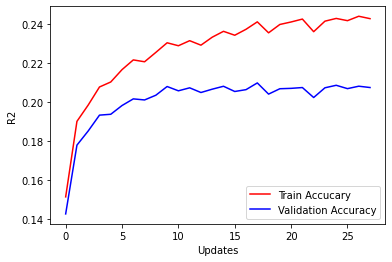

In [87]:
# setting hyperparameters and gettings epoch sizes
batch_size = 4084
num_epochs = 121
num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = X_val.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_r2, train_loss = [], []
valid_r2, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
val_losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

early_stopping = EarlyStopping(patience=10, verbose=False)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss_train = []
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        # compute gradients given loss
        target_batch = y_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        #cur_loss_train.append(batch_loss.item())
    #train_losses.append(np.mean(cur_loss_train))

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(X_train[slce])
        
        preds = output
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(preds.data.numpy())

        cur_loss_train.append(criterion(output, y_train[slce]).item())
    train_losses.append(np.mean(cur_loss_train))
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    cur_loss_val = []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(X_val[slce])
        preds = output
        val_targs += list(y_val[slce].numpy())
        val_preds += list(preds.data.numpy())

        cur_loss_val.append(criterion(output, y_val[slce]).item())

    val_losses.append(np.mean(cur_loss_val))


    train_r2_cur = r2_score(train_targs, train_preds)
    valid_r2_cur = r2_score(val_targs, val_preds)
    
    train_r2.append(train_r2_cur)
    valid_r2.append(valid_r2_cur)

    # EarlyStopping
    early_stopping(val_losses[-1], net)
    if early_stopping.early_stop:
        print("Early stopping")
        print("Epoch %2i: Train Loss %f , Valid Loss %f , Train R2 %f, Valid R2 %f" % (
            epoch+1, train_losses[-1], val_losses[-1], train_r2_cur, valid_r2_cur))
        break
    
    if epoch % 10 == 0:
        print("Epoch %2i: Train Loss %f , Valid Loss %f ,Train R2 %f, Valid R2 %f" % (
                epoch+1, train_losses[-1], val_losses[-1],train_r2_cur, valid_r2_cur))

epoch = np.arange(len(train_r2))
plt.figure()
plt.plot(epoch, train_r2, 'r', epoch, valid_r2, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('R2')

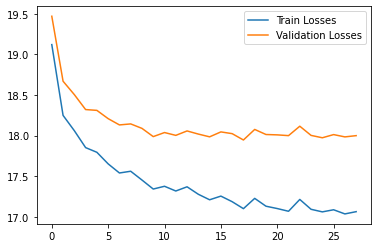

0.20837292920476536


In [88]:
plt.plot(epoch, [x for x in train_losses], [x for x in val_losses])
plt.legend(['Train Losses','Validation Losses'])
plt.show()
print(r2_score(y_test.detach().numpy()[:,0],net.forward(X_test).detach().numpy()[:,0]))